In [283]:
import pandas as pd
import numpy as np

# Limpieza de datos
import re
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score, train_test_split
from pattern.text.en import singularize, lemma
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modelos
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder


In [284]:
data = pd.read_csv("./VirusSample.csv", usecols=lambda x: 'Unnamed' not in x)
print(len(data))
data.head()

9795


,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,"IntersectRect,GetCurrentProcess,GetVersion",Virus
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,"GetCaretBlinkTime,CountClipboardFormats,GetCon...",Virus
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,"VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...",Virus
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,"SetTraceCallback,CopyAcceleratorTableW,GetProc...",Virus
4,021f4aa86b520e1d606ab26699c35546bcd00c27,"SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...",Virus


# Limpiando data

In [285]:
cachedStopWords = stopwords.words('english')
def removeStepWords(value):
  return ' '.join([word for word in value.split(',') if word not in cachedStopWords])

data["api"] = data["api"].apply(removeStepWords)

In [286]:
def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

data["api"] = data["api"].apply(sentenceToPresent)

In [287]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value
    
def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

data["api"] = data["api"].apply(sentenceToSingular)

In [288]:
def removeSpecialChars(value):
    ayuda = re.sub(r"[^a-zA-Z ]",' ', value.lower())
    return ayuda

data["api"] = data["api"].apply(removeSpecialChars)

In [289]:
def removeExtraSpaces(value):
    return re.sub('  +', ' ', value) 

data["api"] = data["api"].apply(removeExtraSpaces)

In [290]:
data.drop(data[data["api"] == "empty"].index, inplace=True)

In [291]:
data.head()

,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,intersectrect getcurrentproce getversion,Virus
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,getcaretblinktime countclipboardformat getcons...,Virus
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,varr pow getclipboardviewer getinputdesktop ge...,Virus
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,settracecallback copyacceleratortablew getproc...,Virus
4,021f4aa86b520e1d606ab26699c35546bcd00c27,shloadnonloadediconoverlayidentifier varui fro...,Virus


In [292]:
print(data['class'].value_counts())

Trojan        6153
Virus         2367
Backdoor       447
Worms          441
Adware         222
Agent          102
Downloader      31
Spyware         11
Ransomware      10
Riskware         4
Dropper          4
Crypt            2
Keylogger        1
Name: class, dtype: int64


In [293]:
viruses_list = data['class'].unique()
balancedDf = pd.DataFrame(columns=data.columns)

for virus in viruses_list:
    selected_data = data.loc[data['class'] == virus][0:300]
    if (len(selected_data) >= 80):
        balancedDf = pd.concat([balancedDf, selected_data])

print(balancedDf['class'].value_counts())

Virus       300
Trojan      300
Backdoor    300
Worms       300
Adware      222
Agent       102
Name: class, dtype: int64


# Wordcloud

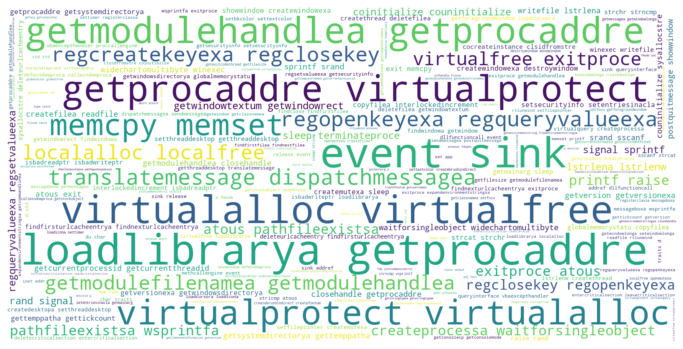

In [294]:
# wordcloud 
body_strings = data["api"].to_list()
body_strings = pd.Series(body_strings).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(body_strings)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [295]:
keyToVal = {}
valToKey = {}
for i, item in enumerate(list(data['class'].unique())):
  keyToVal[i] = item
  valToKey[item] = i

In [296]:
def replaceValToKey(value):
  return valToKey[value] 

data['class'] = data['class'].apply(replaceValToKey)
balancedDf['class'] = balancedDf['class'].apply(replaceValToKey)

In [297]:
data.head()

,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,intersectrect getcurrentproce getversion,0
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,getcaretblinktime countclipboardformat getcons...,0
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,varr pow getclipboardviewer getinputdesktop ge...,0
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,settracecallback copyacceleratortablew getproc...,0
4,021f4aa86b520e1d606ab26699c35546bcd00c27,shloadnonloadediconoverlayidentifier varui fro...,0


# Modelos

In [298]:
def generate_RF_data(received_df):
  dataBodyList = received_df["api"].to_list()

  bv = CountVectorizer(min_df=0.1, max_df=0.8, ngram_range=(1,10))
  bv_matrix = bv.fit_transform(dataBodyList)
  bv_matrix = bv_matrix.toarray()
  vocabulario = bv.get_feature_names_out()
  df_bv = pd.DataFrame(bv_matrix, columns=vocabulario)
  
  
  X = bv_matrix
  y = received_df['class']
  print (X.shape) 
  print (y.shape) 

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
  return [df_bv, X_train, X_test, y_train, y_test]

## Random Forest Classifier

In [299]:
def useRFC(dataToUse):
  df_bv, X_train, X_test, y_train, y_test = generate_RF_data(dataToUse)
  model = RandomForestClassifier(max_depth=12, random_state=42) 
  model = model.fit(X_train, y_train)
  y_preds = model.predict(X_test)

  print ('Accuracy:\t', accuracy_score(y_test, y_preds))
  print ('Precision:\t', precision_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
  print ('Recall:\t\t', recall_score(y_test, y_preds, average='weighted'))
  print ('F1:\t\t', f1_score(y_test, y_preds, average='weighted'))

  y_test = np.reshape(y_test.tolist(), (-1, 1))
  y_preds = np.reshape(y_preds.tolist(), (-1, 1))
  print('Cross-Validation', cross_val_score(model, y_test, y_preds, cv=10))

  return df_bv

### Random Forest Classifier (Imbalanced)

In [300]:
df_bv = useRFC(data)

(9795, 110)
(9795,)
Accuracy:	 0.9105137801973461
Precision:	 0.9113077258785951
Recall:		 0.9105137801973461
F1:		 0.90122336793304


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarn

Cross-Validation [0.93197279 0.91836735 0.92517007 0.92517007 0.92517007 0.92517007
 0.92517007 0.92517007 0.93537415 0.92832765]


In [301]:
df_bv

,atous,closehandle,cocreateinstance,coinitialize,copyfilea,createfilea,createmutexa,createprocessa,createthread,createwindowexa,...,virtualfree,virtualprotect,virtualprotect virtualalloc,virtualprotect virtualalloc virtualfree,virtualquery,waitforsingleobject,widechartomultibyte,winexec,writefile,wsprintfa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Random Forest Classifier (Balanced)

In [302]:
df_bv = useRFC(balancedDf)

(1524, 296)
(1524,)
Accuracy:	 0.9039301310043668
Precision:	 0.9065602691724102
Recall:		 0.9039301310043668
F1:		 0.9040984326864483


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Brand\AppData\Local\Programs\Py

Cross-Validation [0.89130435 0.91304348 0.86956522 0.91304348 0.86956522 0.91304348
 0.93478261 0.89130435 0.93333333 0.91111111]


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [303]:
df_bv

,cexit,cexit malloc,cexit malloc printf,cexit malloc printf raise,cexit malloc printf raise setbuf,cexit malloc printf raise setbuf sprintf,cexit malloc printf raise setbuf sprintf strcpy,charnextum,closehandle,closehandle getsystemdirectorya,...,winexec fdopen open osfhandle fclose cexit,winexec fdopen open osfhandle fclose cexit malloc,winexec fdopen open osfhandle fclose cexit malloc printf,winexec fdopen open osfhandle fclose cexit malloc printf raise,winexec fdopen open osfhandle fclose cexit malloc printf raise setbuf,writefile,writefile createfilea,writeprivateprofilestringa,wsagetlasterror,wsprintfa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,2,0,0,0,0
1520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1521,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1522,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


## SVM

In [304]:
def useSVM(dfToUse):
  df_bv, X_train, X_test, y_train, y_test = generate_RF_data(dfToUse)
  X_train = pd.DataFrame(X_train, columns=df_bv.columns)
  X_train = X_train.apply(pd.to_numeric)
  X_test = pd.DataFrame(X_test, columns=df_bv.columns)
  X_test = X_test.apply(pd.to_numeric)

  #Se transforman las colunas usando los preprocesadores
  numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
  )

  preprocesador = ColumnTransformer([
    ('numerico', numeric_preprocessor, [0,-1])
  ],remainder="passthrough")

  model = make_pipeline(preprocesador, SVC(kernel="linear", C=32, degree=4))
  model = model.fit(X_train, y_train)
  y_preds = model.predict(X_test)

  print ('\nAccuracy:\t', accuracy_score(y_test, y_preds))
  print ('Precision:\t', precision_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
  print ('Recall:\t\t', recall_score(y_test, y_preds, average='weighted'))
  print ('F1:\t\t', f1_score(y_test, y_preds, average='weighted'))

  y_test = np.reshape(y_test.tolist(), (-1, 1))
  y_preds = np.reshape(y_preds.tolist(), (-1, 1))
  print('Cross-Validation', cross_val_score(model, y_test, y_preds, cv=10))

### SVM (Imbalanced)

In [305]:
useSVM(data)

(9795, 110)
(9795,)

Accuracy:	 0.902347737325621
Precision:	 0.9021385528427746
Recall:		 0.902347737325621
F1:		 0.8973097540772832


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expe

Cross-Validation [0.86394558 0.84013605 0.86054422 0.86394558 0.86054422 0.85714286
 0.83673469 0.85034014 0.86054422 0.88054608]


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SVM (Balanced)

In [306]:
useSVM(balancedDf)

(1524, 296)
(1524,)

Accuracy:	 0.9017467248908297
Precision:	 0.9017521889701989
Recall:		 0.9017467248908297
F1:		 0.9009649858099997
Cross-Validation [0.86956522 0.91304348 0.89130435 0.84782609 0.89130435 0.93478261
 0.95652174 0.89130435 0.91111111 0.91111111]


c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataC